# **MODELOS MULTIVARIANTES PARA LA PREDICCIÓN DE LA DEMANDA HIPOTECARIA**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
import numpy as np
from xgboost import XGBRegressor
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from statsmodels.graphics.regressionplots import plot_partregress_grid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.graphics.regressionplots import plot_partregress

# 1. REGRESIÓN LINEAL MÚLTIPLE

In [2]:
# Incorporamos los dos dataframes que vamos a emplear en el modelo:
df_no_corr = pd.read_excel("df_no_corr.xlsx")
iqr_winsorized_df = pd.read_excel("iqr_winsorized_df.xlsx")

In [3]:
df_no_corr.head()

,Fecha,Numero_Hipotecas,Importe_Hipotecas,Numero_Compraventas,Precio_M2_Vivienda,Contratos_Temporales,Ipc_%_Variación_Anual,Duracion_Media_Hipoteca,Tasa_Paro_(%)
0,2003-03-31,263600,23.908609,183908.527902,1230.3,4370.2,3.800000,3.178054,11.99
1,2003-06-30,247071,23.876021,185520.576206,1309.6,4550.9,2.900000,3.178054,11.28
2,2003-09-30,236977,23.900416,187146.754903,1344.9,4652.2,3.000000,3.178054,11.30
3,2003-12-31,241791,23.926874,188787.187852,1380.3,4687.5,2.766667,3.178054,11.37
4,2004-03-31,283170,24.125194,190442.000000,1456.2,4620.7,2.233333,3.218876,11.50


In [4]:
# Nos aseguramos de que la columna 'Fecha' esté en formato datetime y como índice
df_no_corr["Fecha"] = pd.to_datetime(df_no_corr["Fecha"])
df_no_corr.set_index("Fecha", inplace=True)

In [5]:
iqr_winsorized_df = iqr_winsorized_df.drop(['Fecha_ordinal', 'Trimestre_simple', 'Año', 'Periodo'], axis=1)
iqr_winsorized_df.head()

,Fecha,Numero_Hipotecas,Importe_Hipotecas,Valor_Medio_Hipotecas,Tipo_Interes_Medio,Tasa_Paro_(%),Contratos_Indefinidos,Contratos_Temporales,Poblacion,Cantidad_De_Extranjeros,...,Ti_Credito,Renta_Disponible_Bruta,Ipc_%_Variación_Anual,Interes_Fijo_Hipotecas,Interes_Variable_Hipotecas,Afiliaciones_Ss,Duracion_Media_Hipoteca,Numero_Compraventas,Valor_Compraventa,Confianza_Del_Consumidor
0,2003-03-31,263600,23.908609,91713.17,4.693333,11.99,9.166284,4370.2,4.423798e+07,3039702.75,...,3.980500,120199.0,3.800000,5.15,4.29,49006568,3.178054,183908.527902,1.910958e+10,106.382464
1,2003-06-30,247071,23.876021,94711.40,4.453333,11.28,9.180087,4550.9,4.423798e+07,3039702.75,...,3.707333,139387.0,2.900000,5.15,4.29,50002323,3.178054,185520.576206,1.983594e+10,104.702077
2,2003-09-30,236977,23.900416,101184.20,4.213333,11.30,9.191912,4652.2,4.423798e+07,3039702.75,...,3.363667,125491.0,3.000000,5.15,4.29,50159070,3.178054,187146.754903,2.058991e+10,103.048233
3,2003-12-31,241791,23.926874,101828.44,3.883333,11.37,9.196231,4687.5,4.423798e+07,3039702.75,...,3.327000,138587.0,2.766667,5.15,4.29,50194767,3.178054,188787.187852,2.137254e+10,101.420513
4,2004-03-31,283170,24.125194,106020.83,3.760000,11.50,9.201895,4620.7,4.423798e+07,3039702.75,...,3.303333,127391.0,2.233333,4.29,3.59,50448144,3.218876,190442.000000,2.218492e+10,99.818504


In [6]:
# Nos aseguramos de que la columna 'Fecha' esté en formato datetime y como índice
iqr_winsorized_df["Fecha"] = pd.to_datetime(iqr_winsorized_df["Fecha"])
iqr_winsorized_df.set_index("Fecha", inplace=True)

## Paso 1: Ajuste del modelo y obtención de coeficientes para df_no_corr y iqr_winsorized_df

**df_no_corr**

In [7]:
df = df_no_corr.copy()

# Ajuste del modelo
X = df.drop(columns=['Numero_Hipotecas'])
y = df['Numero_Hipotecas']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

# Coeficientes
print("--- Coeficientes del modelo ---")
print(model.params)

--- Coeficientes del modelo ---
const                     -4.134786e+06
Importe_Hipotecas          1.602816e+05
Numero_Compraventas        3.239932e-01
Precio_M2_Vivienda        -1.004606e+02
Contratos_Temporales       2.082219e+01
Ipc_%_Variación_Anual     -2.542549e+03
Duracion_Media_Hipoteca    1.405699e+05
Tasa_Paro_(%)              7.291619e+03
dtype: float64


**iqr_winsorized_df**

In [8]:
df2 = iqr_winsorized_df.copy()

# Ajuste del modelo
X2 = df2.drop(columns=['Numero_Hipotecas'])
y2 = df2['Numero_Hipotecas']
X2 = sm.add_constant(X2)

model2 = sm.OLS(y2, X2).fit()

# Coeficientes
print("--- Coeficientes del modelo ---")
print(model2.params)

--- Coeficientes del modelo ---
const                            1.765667e+06
Importe_Hipotecas                7.346631e+04
Valor_Medio_Hipotecas            1.903861e-01
Tipo_Interes_Medio              -1.767313e+04
Tasa_Paro_(%)                    3.875321e+02
Contratos_Indefinidos           -1.029158e+04
Contratos_Temporales            -1.977115e+01
Poblacion                       -7.150544e-02
Cantidad_De_Extranjeros          3.379368e-02
Pib_Trimestral_Ajustado          3.909575e-01
Pib_Trimestral_No_Ajustado      -4.977535e-01
Ipi_Variacion_Anual_Original     1.841756e+03
Ipi_Variacion_Anual_Corregida   -1.580079e+03
Precio_M2_Vivienda              -3.216741e+01
Euribor_12_Meses                -6.819924e+03
Mro_Rate                         3.942415e+03
Ti_Credito                       1.357752e+04
Renta_Disponible_Bruta           1.154299e-01
Ipc_%_Variación_Anual           -4.488855e+02
Interes_Fijo_Hipotecas           1.350438e+03
Interes_Variable_Hipotecas       5.168192e+03
Af

## Paso 2: Validación de supuestos

### A) Linealidad de los parámetros

**df_no_corr**

In [9]:
reset = linear_reset(model, power=2, use_f=True)
print("--- Ramsey RESET test ---")
print(f"F-stat: {reset.fvalue:.4f}, p-value: {reset.pvalue:.4f}")

if reset.pvalue < 0.05:
    print("⚠️ Se rechaza H0: posible falta de linealidad o forma funcional incorrecta.")
else:
    print("✅ No se rechaza H0: no hay indicios de falta de linealidad o forma funcional incorrecta.")

--- Ramsey RESET test ---
F-stat: 438.8288, p-value: 0.0000
⚠️ Se rechaza H0: posible falta de linealidad o forma funcional incorrecta.


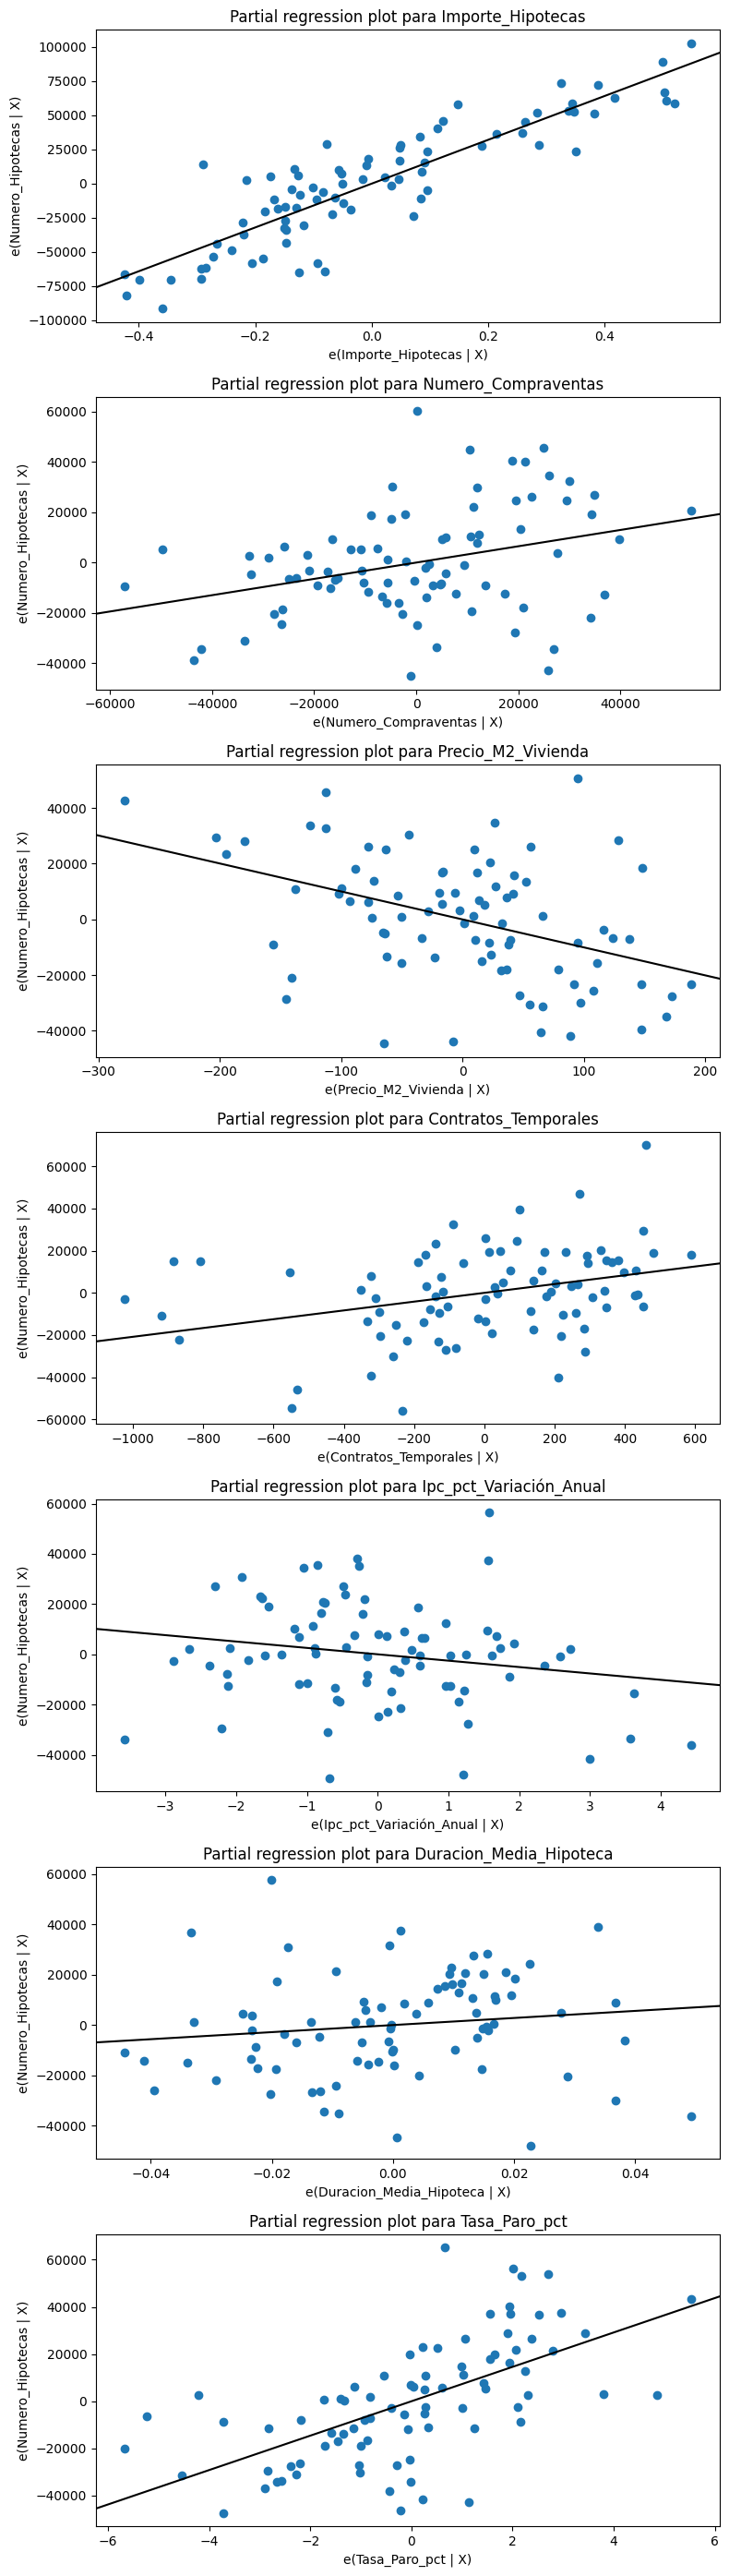

In [10]:
df_temp = df_no_corr.rename(
    columns=lambda x: x.replace(" ", "_").replace("(", "").replace(")", "").replace("%", "pct")
)

independent_vars_temp = [col for col in df_temp.columns if col != "Numero_Hipotecas"]

fig, axes = plt.subplots(len(independent_vars_temp), 1, figsize=(8, 4 * len(independent_vars_temp)))

if len(independent_vars_temp) == 1:
    axes = [axes]

for ax, var in zip(axes, independent_vars_temp):
    # Generamos partial regression plot
    plot_partregress(endog="Numero_Hipotecas",
                     exog_i=var,
                     exog_others=[v for v in independent_vars_temp if v != var],
                     data=df_temp, ax=ax)
    ax.set_title(f'Partial regression plot para {var}')
    
    # Quitar las etiquetas de puntos (textos)
    for txt in ax.texts:
        txt.set_visible(False)

plt.tight_layout()
plt.show()

**iqr_winsorized_df**

In [11]:
reset = linear_reset(model2, power=2, use_f=True)
print("--- Ramsey RESET test ---")
print(f"F-stat: {reset.fvalue:.4f}, p-value: {reset.pvalue:.4f}")

if reset.pvalue < 0.05:
    print("⚠️ Se rechaza H0: posible falta de linealidad o forma funcional incorrecta.")
else:
    print("✅ No se rechaza H0: no hay indicios de falta de linealidad o forma funcional incorrecta.")

--- Ramsey RESET test ---
F-stat: 183.7115, p-value: 0.0000
⚠️ Se rechaza H0: posible falta de linealidad o forma funcional incorrecta.


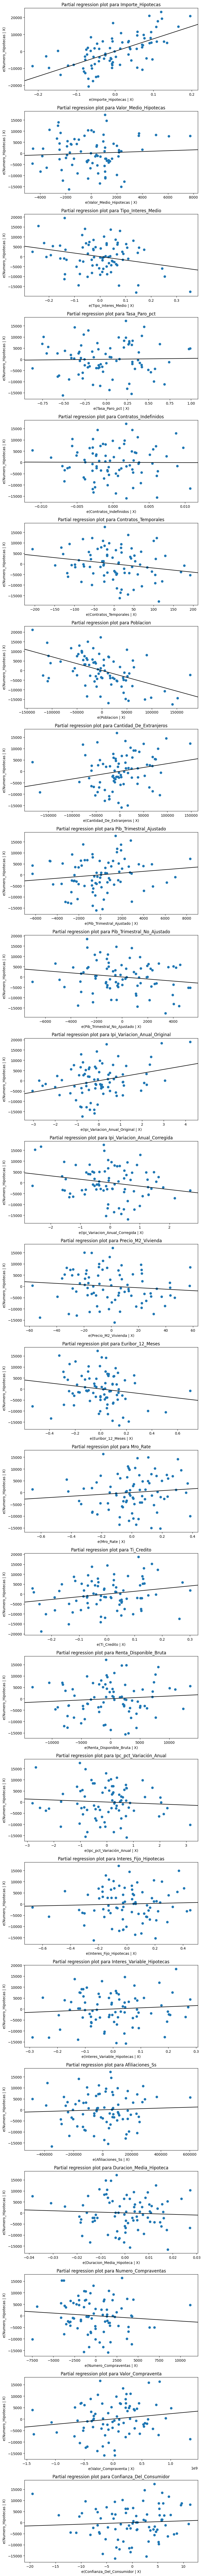

In [12]:
df_temp2 = iqr_winsorized_df.rename(
    columns=lambda x: x.replace(" ", "_").replace("(", "").replace(")", "").replace("%", "pct")
)

independent_vars_temp2 = [col for col in df_temp2.columns if col != "Numero_Hipotecas"]

fig, axes = plt.subplots(len(independent_vars_temp2), 1, figsize=(8, 4 * len(independent_vars_temp2)))

if len(independent_vars_temp2) == 1:
    axes = [axes]

for ax, var in zip(axes, independent_vars_temp2):
    # Generamos partial regression plot
    plot_partregress(endog="Numero_Hipotecas",
                     exog_i=var,
                     exog_others=[v for v in independent_vars_temp2 if v != var],
                     data=df_temp2, ax=ax)
    ax.set_title(f'Partial regression plot para {var}')
    
    # Quitar las etiquetas de puntos (textos)
    for txt in ax.texts:
        txt.set_visible(False)

plt.tight_layout()
plt.show()

### B) No multicolinealidad perfecta (VIF)

**df_no_corr**

In [13]:
print("\n--- Supuesto (b): No multicolinealidad perfecta (VIF) ---")
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

# Excluye la constante al comprobar
max_vif = vif.loc[vif["Variable"] != "const", "VIF"].max()

if max_vif > 10:
    print("⚠️ Puede haber problemas de multicolinealidad (VIF > 10).")
else:
    print("✅ No se detecta multicolinealidad preocupante (VIF < 10).")



--- Supuesto (b): No multicolinealidad perfecta (VIF) ---
                  Variable           VIF
0                    const  29824.528622
1        Importe_Hipotecas      8.013996
2      Numero_Compraventas      5.201562
3       Precio_M2_Vivienda      4.524857
4     Contratos_Temporales      4.068406
5    Ipc_%_Variación_Anual      1.637125
6  Duracion_Media_Hipoteca      6.146076
7            Tasa_Paro_(%)      6.320993
✅ No se detecta multicolinealidad preocupante (VIF < 10).


**iqr_winsorized_df**

In [14]:
print("\n--- Supuesto (b): No multicolinealidad perfecta (VIF) ---")
vif = pd.DataFrame()
vif["Variable"] = X2.columns
vif["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
print(vif)

if vif['VIF'].max() > 10:
    print("⚠️ Puede haber problemas de multicolinealidad (VIF > 10).")
else:
    print("✅ No se detecta multicolinealidad preocupante (VIF < 10).")


--- Supuesto (b): No multicolinealidad perfecta (VIF) ---
                         Variable           VIF
0                           const  3.937241e+06
1               Importe_Hipotecas  6.949783e+01
2           Valor_Medio_Hipotecas  4.968165e+01
3              Tipo_Interes_Medio  6.324364e+01
4                   Tasa_Paro_(%)  1.876463e+02
5           Contratos_Indefinidos  4.030348e+02
6            Contratos_Temporales  8.321645e+01
7                       Poblacion  3.782105e+02
8         Cantidad_De_Extranjeros  2.343229e+02
9         Pib_Trimestral_Ajustado  1.901425e+02
10     Pib_Trimestral_No_Ajustado  2.035008e+02
11   Ipi_Variacion_Anual_Original  9.601749e+00
12  Ipi_Variacion_Anual_Corregida  1.290828e+01
13             Precio_M2_Vivienda  6.786734e+01
14               Euribor_12_Meses  7.886384e+01
15                       Mro_Rate  6.418439e+01
16                     Ti_Credito  8.177181e+01
17         Renta_Disponible_Bruta  2.436555e+01
18          Ipc_%_Variación_A

### C) Esperanza cero del error

**df_no_corr**

In [15]:
residuals = model.resid
mean_resid = np.mean(residuals)

print("\n--- Supuesto (c): Esperanza cero del error ---")
print(f"Media de los residuos: {mean_resid:.5f}")
if abs(mean_resid) < 0.01:
    print("✅ Media de residuos próxima a cero.")
else:
    print("⚠️ Media de residuos algo alejada de cero.")



--- Supuesto (c): Esperanza cero del error ---
Media de los residuos: 0.00000
✅ Media de residuos próxima a cero.


**iqr_winsorized_df**

In [16]:
residuals2 = model2.resid
mean_resid2 = np.mean(residuals2)

print("\n--- Supuesto (c): Esperanza cero del error ---")
print(f"Media de los residuos: {mean_resid2:.5f}")
if abs(mean_resid2) < 0.01:
    print("✅ Media de residuos próxima a cero.")
else:
    print("⚠️ Media de residuos algo alejada de cero.")



--- Supuesto (c): Esperanza cero del error ---
Media de los residuos: -0.08119
⚠️ Media de residuos algo alejada de cero.


### D) Homocedasticidad

**df_no_corr**

In [17]:
print("\n--- Supuesto (d): Homocedasticidad (Breusch-Pagan test) ---")
bp_test = het_breuschpagan(residuals, X)
labels = ['LM stat', 'LM p-val', 'F stat', 'F p-val']
for l, r in zip(labels, bp_test):
    print(f"{l}: {r:.4f}")

if bp_test[1] < 0.05:
    print("⚠️ Se rechaza homocedasticidad: posible heterocedasticidad.")
else:
    print("✅ No se rechaza homocedasticidad.")



--- Supuesto (d): Homocedasticidad (Breusch-Pagan test) ---
LM stat: 8.7574
LM p-val: 0.2705
F stat: 1.2636
F p-val: 0.2797
✅ No se rechaza homocedasticidad.


**iqr_winsorized_df**

In [18]:
print("\n--- Supuesto (d): Homocedasticidad (Breusch-Pagan test) ---")
bp_test2 = het_breuschpagan(residuals2, X2)
labels2 = ['LM stat', 'LM p-val', 'F stat', 'F p-val']
for l, r in zip(labels2, bp_test2):
    print(f"{l}: {r:.4f}")

if bp_test2[1] < 0.05:
    print("⚠️ Se rechaza homocedasticidad: posible heterocedasticidad.")
else:
    print("✅ No se rechaza homocedasticidad.")



--- Supuesto (d): Homocedasticidad (Breusch-Pagan test) ---
LM stat: 31.4902
LM p-val: 0.1733
F stat: 1.3913
F p-val: 0.1505
✅ No se rechaza homocedasticidad.


### E) No autocorrelación de los errores

**df_no_corr**


--- Supuesto (e): No autocorrelación (Durbin-Watson) ---
Durbin-Watson: 0.4591
⚠️ Posibles problemas de autocorrelación.


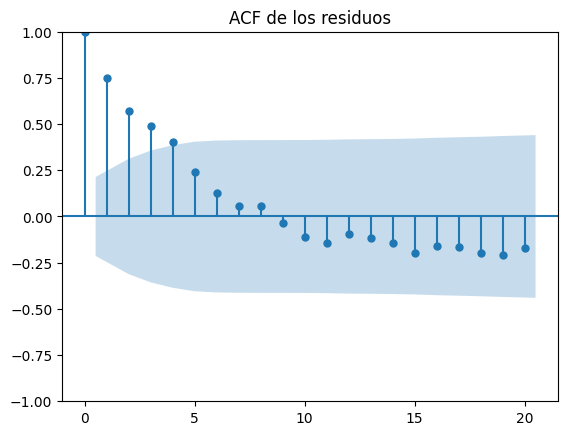

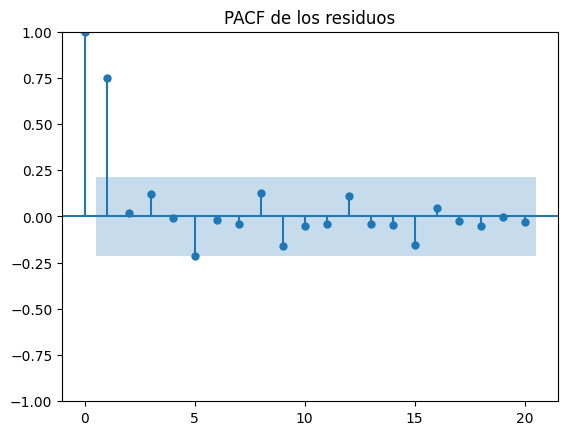

In [19]:
print("\n--- Supuesto (e): No autocorrelación (Durbin-Watson) ---")
dw = durbin_watson(residuals)
print(f"Durbin-Watson: {dw:.4f}")
if 1.5 < dw < 2.5:
    print("✅ No hay indicios claros de autocorrelación.")
else:
    print("⚠️ Posibles problemas de autocorrelación.")

plot_acf(residuals)
plt.title("ACF de los residuos")
plt.show()

plot_pacf(residuals)
plt.title("PACF de los residuos")
plt.show()


**iqr_winsorized_df**


--- Supuesto (e): No autocorrelación (Durbin-Watson) ---
Durbin-Watson: 1.5188
✅ No hay indicios claros de autocorrelación.


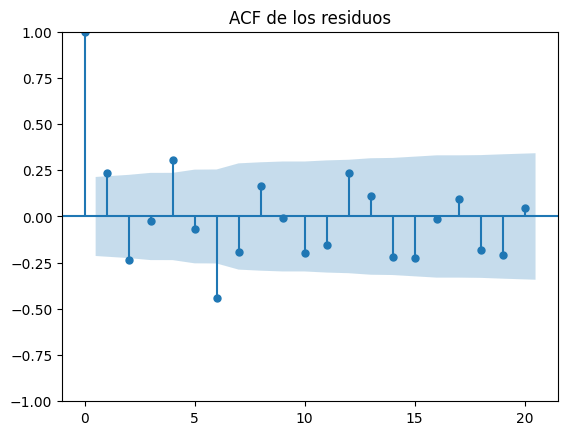

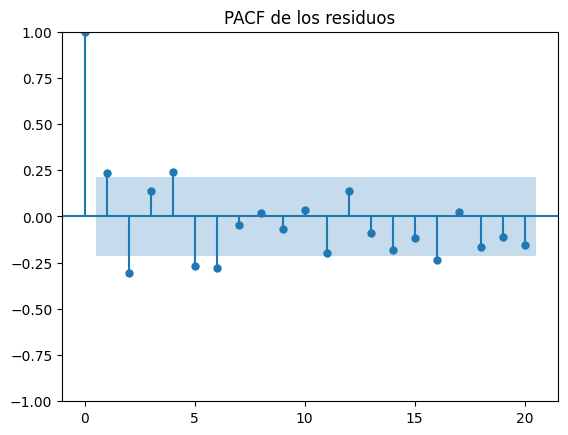

In [20]:
print("\n--- Supuesto (e): No autocorrelación (Durbin-Watson) ---")
dw2 = durbin_watson(residuals2)
print(f"Durbin-Watson: {dw2:.4f}")
if 1.5 < dw2 < 2.5:
    print("✅ No hay indicios claros de autocorrelación.")
else:
    print("⚠️ Posibles problemas de autocorrelación.")

plot_acf(residuals2)
plt.title("ACF de los residuos")
plt.show()

plot_pacf(residuals2)
plt.title("PACF de los residuos")
plt.show()

### F) Normalidad de los errores

**df_no_corr**


--- Supuesto (f): Normalidad de los residuos (Shapiro-Wilk) ---
Estadístico: 0.9935, p-valor: 0.9545
✅ No se rechaza normalidad de los residuos.


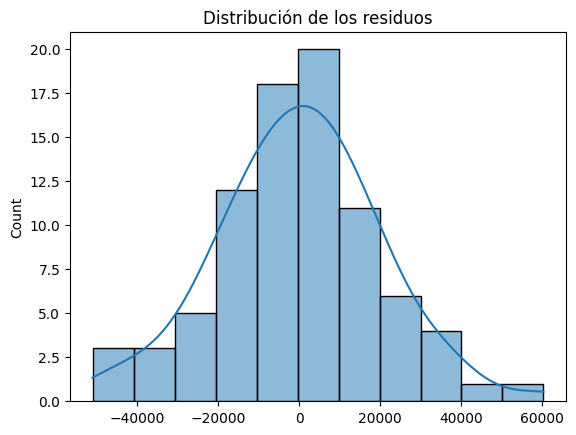

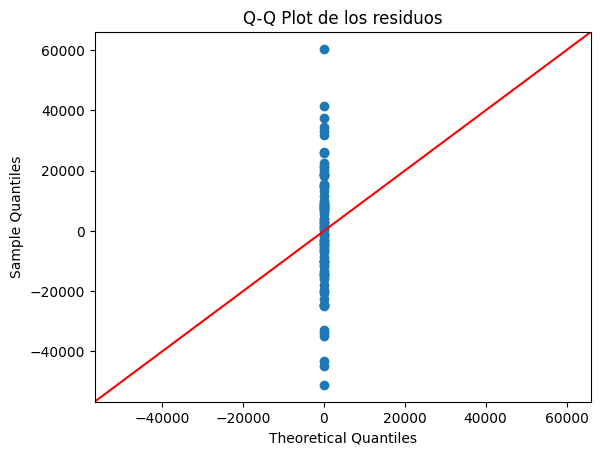

In [21]:
print("\n--- Supuesto (f): Normalidad de los residuos (Shapiro-Wilk) ---")
shap = shapiro(residuals)
print(f"Estadístico: {shap[0]:.4f}, p-valor: {shap[1]:.4f}")
if shap[1] < 0.05:
    print("⚠️ Se rechaza normalidad de los residuos.")
else:
    print("✅ No se rechaza normalidad de los residuos.")

sns.histplot(residuals, kde=True)
plt.title("Distribución de los residuos")
plt.show()

sm.qqplot(residuals, line='45')
plt.title("Q-Q Plot de los residuos")
plt.show()

**iqr_winsorized_df**


--- Supuesto (f): Normalidad de los residuos (Shapiro-Wilk) ---
Estadístico: 0.9926, p-valor: 0.9212
✅ No se rechaza normalidad de los residuos.


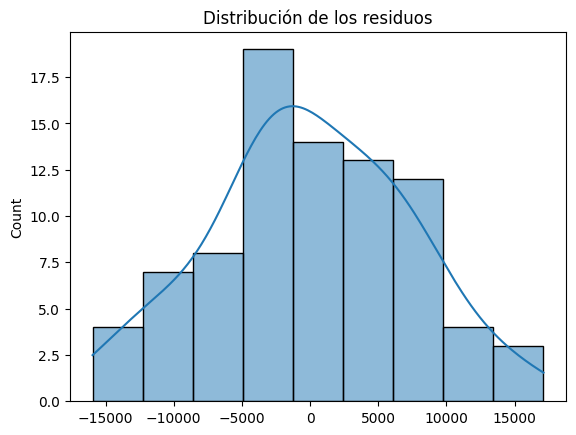

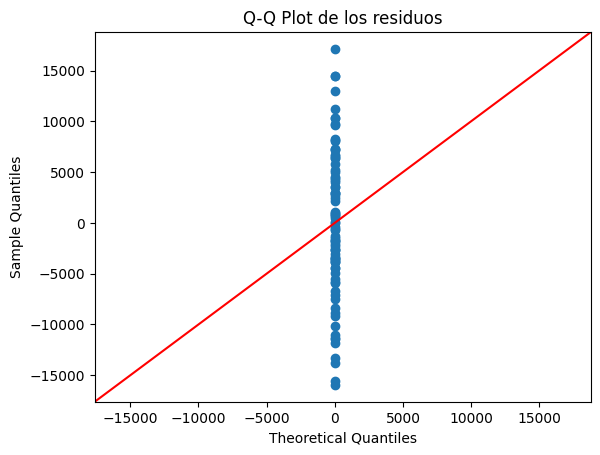

In [22]:
print("\n--- Supuesto (f): Normalidad de los residuos (Shapiro-Wilk) ---")
shap2 = shapiro(residuals2)
print(f"Estadístico: {shap2[0]:.4f}, p-valor: {shap2[1]:.4f}")
if shap2[1] < 0.05:
    print("⚠️ Se rechaza normalidad de los residuos.")
else:
    print("✅ No se rechaza normalidad de los residuos.")

sns.histplot(residuals2, kde=True)
plt.title("Distribución de los residuos")
plt.show()

sm.qqplot(residuals2, line='45')
plt.title("Q-Q Plot de los residuos")
plt.show()

### E) Resultados y limitaciones del modelo

El conjunto de datos para el cual son válidos un mayor número de supuestos es df_no_corr, obtenido tras la eliminación de las variables con mayor correlación (entre sí y con la variable objetivo) en el anterior notebook. 

Este dataset **cumple** con:

* No multicolinealidad preocupante.
* Homocedasticidad.
* Normalidad de los errores.
* Esperanza cero del error.
  
Sin embargo, **no cumple** con:

* Linealidad de los parámetros: la relación entre la variable dependiente (Numero_Hipotecas) y las variables independientes no está bien capturada mediante una relación lineal. Por tanto, los coeficientes estimados no representan correctamente el efecto marginal de cada variable. Es decir, un coeficiente β no indica el cambio esperado en Y ante un cambio unitario en X, porque la relación no es lineal. 
* No autocorrelación de los errores: esto indica que los errores no son independientes y, por tanto, que las predicciones pueden ser menos fiables, sobre todo para series temporales, como es nuestro caso. 

Tras observar los gráficos partial regression plots del apartado **A) Linealidad de los parámetros** podemos decir que las variables con patrones que sugieren una posible no linealidad son: Numero_Compraventas, IPC_%_Variacion_Anual, Duracion_Media_Hipoteca y Contratos_Temporales, ya que muestran una nubes de puntos con elevada dispersión y patrones que no son claros. 
Por tanto, vamos a aplicar **distintas transformaciones (logaritmicas, cuadrados...)** a dichas variables para ver si así conseguimos mejorar la linealidad de los parámetros.

In [23]:
df_no_corr2 = df_no_corr.copy()
df_no_corr2['log_Contratos_Temporales'] = np.log1p(df_no_corr2['Contratos_Temporales'] - df_no_corr2['Contratos_Temporales'].min() + 1)
df_no_corr2['log_Numero_Compraventas'] = np.log1p(df_no_corr2['Numero_Compraventas'])
df_no_corr2['Ipc_%_Variación_Anual_cuadrado'] = df_no_corr2['Ipc_%_Variación_Anual'] ** 2
df_no_corr2['sqrt_Duracion_Media_Hipoteca'] = np.sqrt(df_no_corr2['Duracion_Media_Hipoteca'] - df_no_corr2['Duracion_Media_Hipoteca'].min() + 1)
df_no_corr2 = df_no_corr2.drop(['Contratos_Temporales', 'Numero_Compraventas', 'Ipc_%_Variación_Anual', 'Duracion_Media_Hipoteca'], axis=1)
df_no_corr2.head()

,Numero_Hipotecas,Importe_Hipotecas,Precio_M2_Vivienda,Tasa_Paro_(%),log_Contratos_Temporales,log_Numero_Compraventas,Ipc_%_Variación_Anual_cuadrado,sqrt_Duracion_Media_Hipoteca
Fecha,,,,,,,,
2003-03-31,263600,23.908609,1230.3,11.99,7.216416,12.122199,14.440000,1.021058
2003-06-30,247071,23.876021,1309.6,11.28,7.341030,12.130926,8.410000,1.021058
2003-09-30,236977,23.900416,1344.9,11.30,7.404644,12.139654,9.000000,1.021058
2003-12-31,241791,23.926874,1380.3,11.37,7.425894,12.148381,7.654444,1.021058
2004-03-31,283170,24.125194,1456.2,11.50,7.385293,12.157108,4.987778,1.040856


In [24]:
df3 = df_no_corr2.copy()

# Ajuste del modelo
X3 = df3.drop(columns=['Numero_Hipotecas'])
y3 = df3['Numero_Hipotecas']
X3 = sm.add_constant(X3)

model3 = sm.OLS(y3, X3).fit()

# Coeficientes
print("--- Coeficientes del modelo ---")
print(model3.params)

--- Coeficientes del modelo ---
const                            -4.848632e+06
Importe_Hipotecas                 1.788336e+05
Precio_M2_Vivienda               -1.347996e+02
Tasa_Paro_(%)                     6.318497e+03
log_Contratos_Temporales         -1.175551e+03
log_Numero_Compraventas           2.921793e+04
Ipc_%_Variación_Anual_cuadrado   -7.618683e+02
sqrt_Duracion_Media_Hipoteca      5.788712e+05
dtype: float64


In [25]:
reset = linear_reset(model3, power=2, use_f=True)
print("--- Ramsey RESET test ---")
print(f"F-stat: {reset.fvalue:.4f}, p-value: {reset.pvalue:.4f}")

if reset.pvalue < 0.05:
    print("⚠️ Se rechaza H0: posible falta de linealidad o forma funcional incorrecta.")
else:
    print("✅ No se rechaza H0: no hay indicios de falta de linealidad o forma funcional incorrecta.")

--- Ramsey RESET test ---
F-stat: 527.3797, p-value: 0.0000
⚠️ Se rechaza H0: posible falta de linealidad o forma funcional incorrecta.


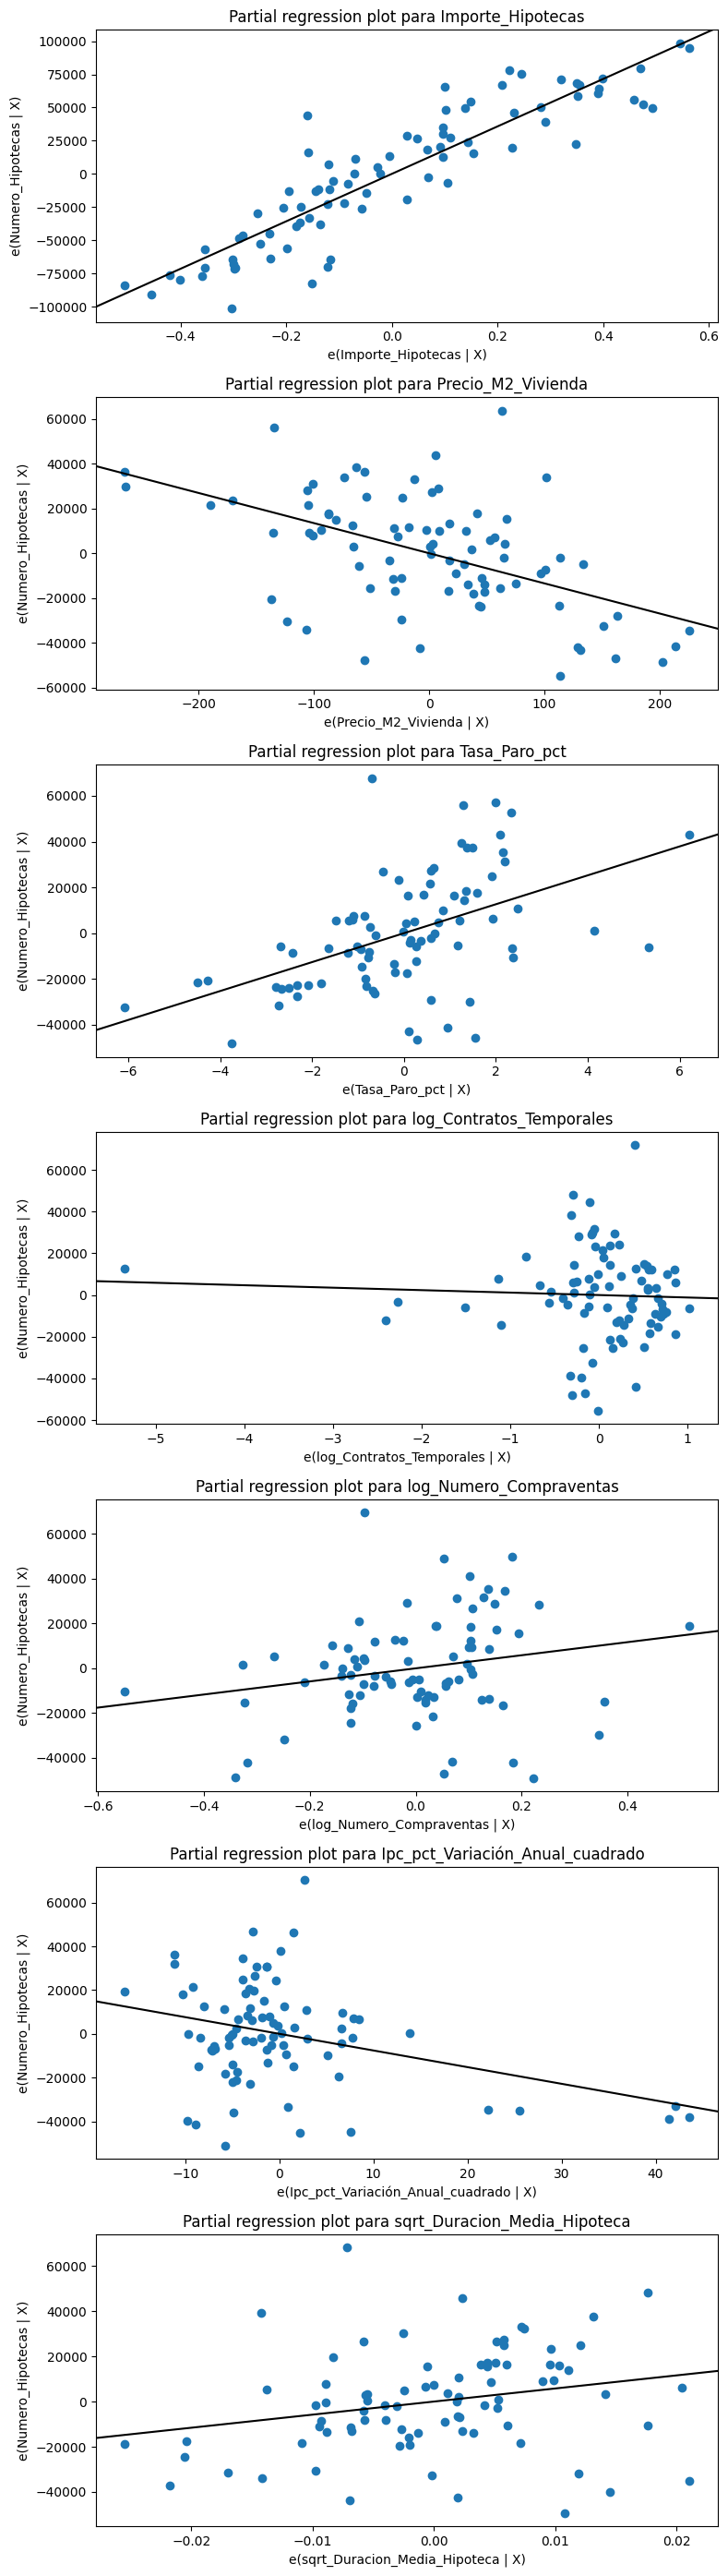

In [26]:
df_temp3 = df_no_corr2.rename(
    columns=lambda x: x.replace(" ", "_").replace("(", "").replace(")", "").replace("%", "pct")
)

independent_vars_temp3 = [col for col in df_temp3.columns if col != "Numero_Hipotecas"]

fig, axes = plt.subplots(len(independent_vars_temp3), 1, figsize=(8, 4 * len(independent_vars_temp3)))

if len(independent_vars_temp3) == 1:
    axes = [axes]

for ax, var in zip(axes, independent_vars_temp3):
    # Generamos partial regression plot
    plot_partregress(endog="Numero_Hipotecas",
                     exog_i=var,
                     exog_others=[v for v in independent_vars_temp3 if v != var],
                     data=df_temp3, ax=ax)
    ax.set_title(f'Partial regression plot para {var}')
    
    # Quitar las etiquetas de puntos (textos)
    for txt in ax.texts:
        txt.set_visible(False)

plt.tight_layout()
plt.show()

Comprobamos que, aplicando las transformaciones, **sigue sin cumplirse el supuesto de A) Linealidad de los parámetros**, por lo que lo más probable es que lo óptimo sea utilizar otro tipo de modelo que no sea lineal (limitación del modelo de regresión lineal múltiple). 

Aún así, procedemos a realizar una predicción con dicho modelo para evaluar en qué medida predice correctamente los datos de hipotecas concedidas de 2023. Sin embargo, por las razones que hemos expuesto, es muy probable que el modelo lineal ajuste peror, que los coeficientes sean sesgados o que pierdan potencia estadísitica. 

En definitiva, **los coeficientes obtenidos se deben interpretar con cautela**. No obstante, a veces el modelo global puede predecir bien (aunque se reduzca la validez a la hora de inferir el efecto de cada variable en la variable objetivo). 

## Paso 3: Predicciones

### A) Predicción sobre df_no_corr sin transformación de variables no lineales

MAE: 22884.61
RMSE: 25110.96
R²: -8.41


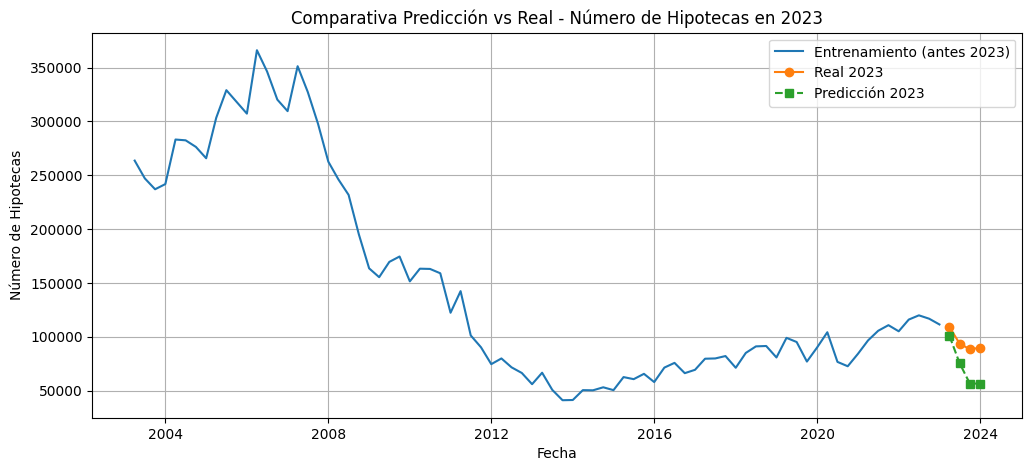

In [27]:
# Aseguramos que el índice es datetime
df.index = pd.to_datetime(df.index)

# --- Datos entrenamiento (antes de 2023) ---
serie_train = df[df.index.year < 2023]['Numero_Hipotecas']

# --- Preparar datos de 2023 ---
X_2023 = df[df.index.year == 2023].drop(columns=['Numero_Hipotecas'])
y_2023 = df[df.index.year == 2023]['Numero_Hipotecas']
X_2023 = sm.add_constant(X_2023)

# --- Predicciones ---
y_pred_2023 = model.predict(X_2023)

# --- Evaluación ---
mae = mean_absolute_error(y_2023, y_pred_2023)
rmse = np.sqrt(mean_squared_error(y_2023, y_pred_2023))
r2 = r2_score(y_2023, y_pred_2023)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- Comparativa gráfica estilo SARIMA ---

plt.figure(figsize=(12,5))

# Serie entrenamiento
plt.plot(serie_train, label="Entrenamiento (antes 2023)")

# Serie real 2023
plt.plot(y_2023.index, y_2023.values, label="Real 2023", marker='o')

# Predicción 2023 (línea discontinua y marcador distinto)
plt.plot(y_2023.index, y_pred_2023.values, label="Predicción 2023", linestyle='--', marker='s')

plt.title("Comparativa Predicción vs Real - Número de Hipotecas en 2023")
plt.xlabel("Fecha")
plt.ylabel("Número de Hipotecas")
plt.legend()
plt.grid(True)
plt.show()

MAE: 22884.61
RMSE: 25110.96
R²: -8.41


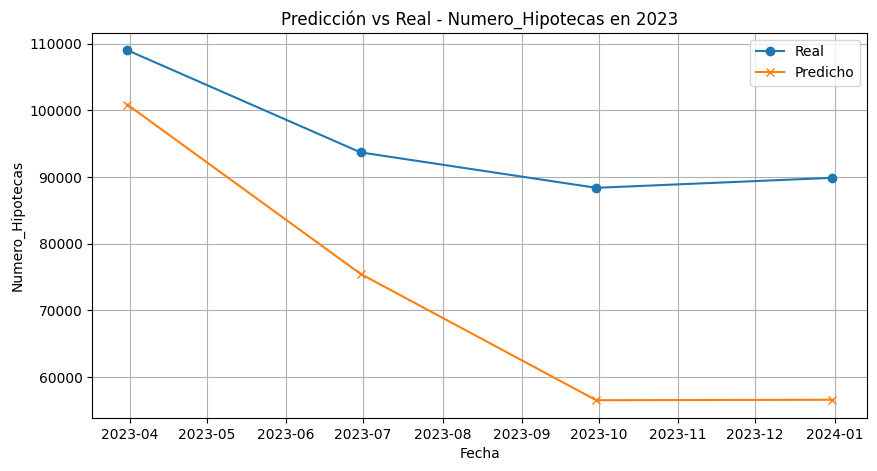

In [28]:
# Aseguramos que el índice es datetime
df.index = pd.to_datetime(df.index)

# --- Preparar datos de 2023 ---
X_2023 = df[df.index.year == 2023].drop(columns=['Numero_Hipotecas'])
y_2023 = df[df.index.year == 2023]['Numero_Hipotecas']
X_2023 = sm.add_constant(X_2023)

# --- Predicciones ---
y_pred_2023 = model.predict(X_2023)

# --- Evaluación ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_2023, y_pred_2023)
rmse = np.sqrt(mean_squared_error(y_2023, y_pred_2023))
r2 = r2_score(y_2023, y_pred_2023)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- Comparativa gráfica ---

plt.figure(figsize=(10,5))
plt.plot(y_2023.index, y_2023.values, label='Real', marker='o')
plt.plot(y_2023.index, y_pred_2023.values, label='Predicho', marker='x')
plt.title('Predicción vs Real - Numero_Hipotecas en 2023')
plt.xlabel('Fecha')
plt.ylabel('Numero_Hipotecas')
plt.legend()
plt.grid()
plt.show()

In [29]:
df_diferencias = pd.DataFrame({
    'Real': y_2023,
    'Predicho': y_pred_2023,
    'Diferencia': y_2023 - y_pred_2023
})

print(df_diferencias)

              Real       Predicho    Diferencia
Fecha                                          
2023-03-31  109020  100860.156210   8159.843790
2023-06-30   93695   75469.953935  18225.046065
2023-09-30   88378   56513.816158  31864.183842
2023-12-31   89873   56583.652900  33289.347100


In [30]:
# Diferencia total absoluta (suma de |real - predicho|)
diferencia_absoluta = (y_2023 - y_pred_2023).abs().sum()
print(f"Diferencia absoluta total: {diferencia_absoluta:.2f}")

Diferencia absoluta total: 91538.42


### B) Predicción sobre df_no_corr con transformación de variables no lineales

MAE: 8795.90
RMSE: 9454.46
R²: -0.33


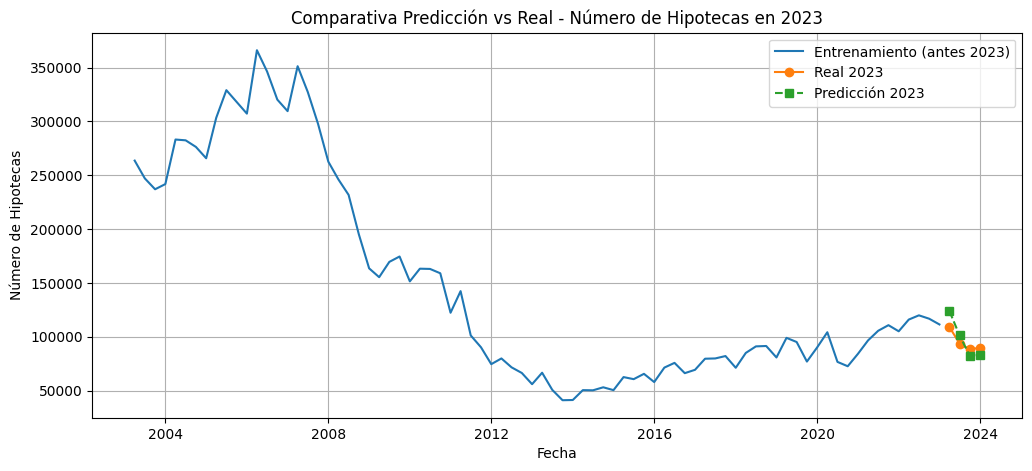

In [31]:
# Aseguramos que el índice es datetime
df3.index = pd.to_datetime(df3.index)

# --- Datos entrenamiento (antes de 2023) ---
serie_train = df3[df3.index.year < 2023]['Numero_Hipotecas']

# --- Preparar datos de 2023 ---
X_2023 = df3[df3.index.year == 2023].drop(columns=['Numero_Hipotecas'])
y_2023 = df3[df3.index.year == 2023]['Numero_Hipotecas']
X_2023 = sm.add_constant(X_2023)

# --- Predicciones ---
y_pred_2023 = model3.predict(X_2023)

# --- Evaluación ---
mae = mean_absolute_error(y_2023, y_pred_2023)
rmse = np.sqrt(mean_squared_error(y_2023, y_pred_2023))
r2 = r2_score(y_2023, y_pred_2023)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- Comparativa gráfica estilo SARIMA ---

plt.figure(figsize=(12,5))

# Serie entrenamiento
plt.plot(serie_train, label="Entrenamiento (antes 2023)")

# Serie real 2023
plt.plot(y_2023.index, y_2023.values, label="Real 2023", marker='o')

# Predicción 2023 (línea discontinua y marcador distinto)
plt.plot(y_2023.index, y_pred_2023.values, label="Predicción 2023", linestyle='--', marker='s')

plt.title("Comparativa Predicción vs Real - Número de Hipotecas en 2023")
plt.xlabel("Fecha")
plt.ylabel("Número de Hipotecas")
plt.legend()
plt.grid(True)
plt.show()


MAE: 8795.90
RMSE: 9454.46
R²: -0.33


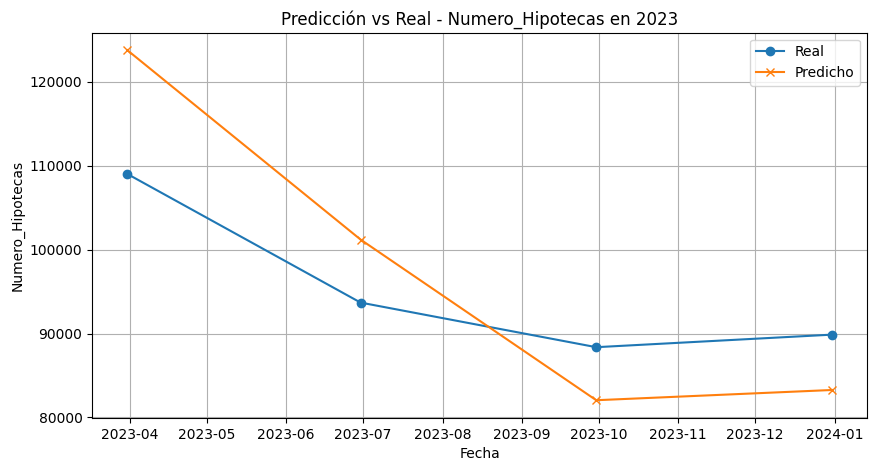

In [32]:
# Aseguramos que el índice es datetime
df3.index = pd.to_datetime(df3.index)

# --- Preparar datos de 2023 ---
X_2023 = df3[df3.index.year == 2023].drop(columns=['Numero_Hipotecas'])
y_2023 = df3[df3.index.year == 2023]['Numero_Hipotecas']
X_2023 = sm.add_constant(X_2023)

# --- Predicciones ---
y_pred_2023 = model3.predict(X_2023)

# --- Evaluación ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_2023, y_pred_2023)
rmse = np.sqrt(mean_squared_error(y_2023, y_pred_2023))
r2 = r2_score(y_2023, y_pred_2023)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- Comparativa gráfica ---

plt.figure(figsize=(10,5))
plt.plot(y_2023.index, y_2023.values, label='Real', marker='o')
plt.plot(y_2023.index, y_pred_2023.values, label='Predicho', marker='x')
plt.title('Predicción vs Real - Numero_Hipotecas en 2023')
plt.xlabel('Fecha')
plt.ylabel('Numero_Hipotecas')
plt.legend()
plt.grid()
plt.show()

In [33]:
df_diferencias2 = pd.DataFrame({
    'Real': y_2023,
    'Predicho': y_pred_2023,
    'Diferencia': y_2023 - y_pred_2023
})

print(df_diferencias2)

              Real       Predicho    Diferencia
Fecha                                          
2023-03-31  109020  123771.706423 -14751.706423
2023-06-30   93695  101208.999613  -7513.999613
2023-09-30   88378   82056.847420   6321.152580
2023-12-31   89873   83276.254000   6596.746000


In [34]:
# Diferencia total absoluta (suma de |real - predicho|)
diferencia_absoluta = (y_2023 - y_pred_2023).abs().sum()
print(f"Diferencia absoluta total: {diferencia_absoluta:.2f}")


Diferencia absoluta total: 35183.60


### C) Predicción sobre iqr_winsorized_df con transformación de variables no lineales

MAE: 4844.31
RMSE: 5379.12
R²: 0.57


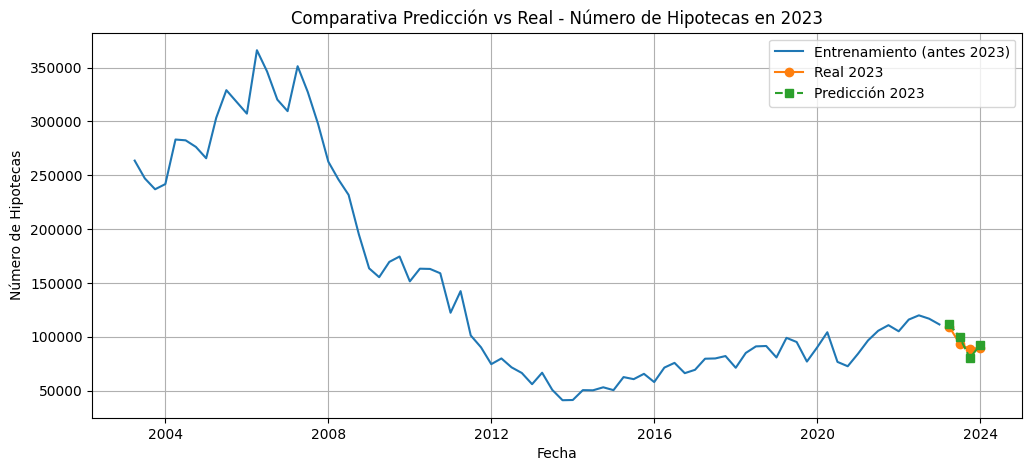

In [35]:
# Aseguramos que el índice es datetime
df2.index = pd.to_datetime(df2.index)

# Columnas que usó el modelo para entrenar (incluida la constante)
cols_modelo = model2.model.exog_names

# --- Datos entrenamiento (antes de 2023) ---
serie_train = df2[df2.index.year < 2023]['Numero_Hipotecas']

# --- Preparar datos de 2023 ---
X_2023 = df2[df2.index.year == 2023].drop(columns=['Numero_Hipotecas'])

# Añadimos constante (asegurando que solo haya una)
X_2023 = sm.add_constant(X_2023, has_constant='add')

# Añadir columnas faltantes con ceros
for col in cols_modelo:
    if col not in X_2023.columns:
        X_2023[col] = 0

# Reordenar columnas para que coincidan con el modelo
X_2023 = X_2023[cols_modelo]

# Variable objetivo 2023
y_2023 = df2[df2.index.year == 2023]['Numero_Hipotecas']

# --- Predicciones ---
y_pred_2023 = model2.predict(X_2023)

# --- Evaluación ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_2023, y_pred_2023)
rmse = np.sqrt(mean_squared_error(y_2023, y_pred_2023))
r2 = r2_score(y_2023, y_pred_2023)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- Comparativa gráfica estilo SARIMA ---

plt.figure(figsize=(12,5))

# Serie entrenamiento
plt.plot(serie_train, label="Entrenamiento (antes 2023)")

# Serie real 2023
plt.plot(y_2023.index, y_2023.values, label="Real 2023", marker='o')

# Predicción 2023 (línea discontinua y marcador distinto)
plt.plot(y_2023.index, y_pred_2023.values, label="Predicción 2023", linestyle='--', marker='s')

plt.title("Comparativa Predicción vs Real - Número de Hipotecas en 2023")
plt.xlabel("Fecha")
plt.ylabel("Número de Hipotecas")
plt.legend()
plt.grid(True)
plt.show()

MAE: 4844.31
RMSE: 5379.12
R²: 0.57


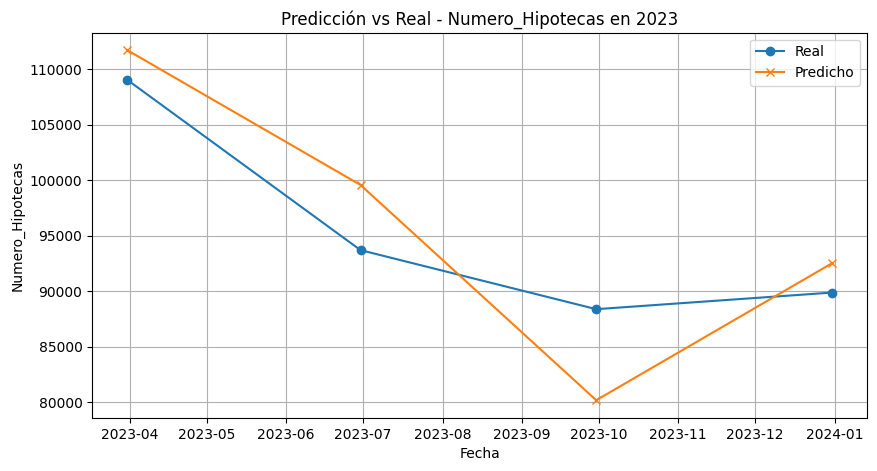

In [36]:
# Aseguramos que el índice es datetime
df2.index = pd.to_datetime(df2.index)

# Columnas que usó el modelo para entrenar (incluida la constante)
cols_modelo = model2.model.exog_names  # lista de columnas que el modelo espera

# --- Preparar datos de 2023 ---
X_2023 = df2[df2.index.year == 2023].drop(columns=['Numero_Hipotecas'])

# Añadimos constante (asegurándonos que solo haya una)
X_2023 = sm.add_constant(X_2023, has_constant='add')

# Añadir columnas faltantes con ceros
for col in cols_modelo:
    if col not in X_2023.columns:
        X_2023[col] = 0

# Reordenar columnas para que coincidan exactamente con las del modelo
X_2023 = X_2023[cols_modelo]

# Variable objetivo para 2023
y_2023 = df2[df2.index.year == 2023]['Numero_Hipotecas']

# --- Predicciones ---
y_pred_2023 = model2.predict(X_2023)

# --- Evaluación ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_2023, y_pred_2023)
rmse = np.sqrt(mean_squared_error(y_2023, y_pred_2023))
r2 = r2_score(y_2023, y_pred_2023)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- Comparativa gráfica ---

plt.figure(figsize=(10,5))
plt.plot(y_2023.index, y_2023.values, label='Real', marker='o')
plt.plot(y_2023.index, y_pred_2023.values, label='Predicho', marker='x')
plt.title('Predicción vs Real - Numero_Hipotecas en 2023')
plt.xlabel('Fecha')
plt.ylabel('Numero_Hipotecas')
plt.legend()
plt.grid()
plt.show()
y_pred_2023 = model2.predict(X_2023)

In [37]:
df_diferencias3 = pd.DataFrame({
    'Real': y_2023,
    'Predicho': y_pred_2023,
    'Diferencia': y_2023 - y_pred_2023
})

print(df_diferencias3)

              Real       Predicho   Diferencia
Fecha                                         
2023-03-31  109020  111696.685140 -2676.685140
2023-06-30   93695   99559.636311 -5864.636311
2023-09-30   88378   80178.603024  8199.396976
2023-12-31   89873   92509.511736 -2636.511736


In [38]:
# Diferencia total absoluta (suma de |real - predicho|)
diferencia_absoluta = (y_2023 - y_pred_2023).abs().sum()
print(f"Diferencia absoluta total: {diferencia_absoluta:.2f}")

Diferencia absoluta total: 19377.23


## Paso 4: Resultados y conclusiones

**Análisis por modelo**

**Modelo 1 (df_no_corr sin transformaciones)**
- Métricas malas (R² negativo muy alto), error absoluto muy alto.

- No se cumplen dos supuestos clave: linealidad y no autocorrelación.

- El modelo no funciona bien para predecir la variable objetivo, probablemente subajustado o mal especificado.

- El error total de predicción es enorme (más de 100k hipotecas de diferencia total), por lo que no es útil.

**Modelo 2 (df_no_corr con transformaciones)**
- Métricas mejoran mucho respecto al Modelo 1, pero siguen siendo malas: R² negativo (-1.28) indica que aún predice peor que la media.

- Los supuestos problemáticos son los mismos que en el Modelo 1, indicando que la estructura del modelo sigue sin ajustarse bien a la realidad.

- El error total absoluto baja bastante (casi 42k hipotecas), pero sigue siendo elevado.

- Mejor que Modelo 1, pero aún insuficiente.

**Modelo 3 (iqr_winsorized_df con todas variables)**
- Métricas muy buenas: R² = 0.89 indica que el modelo explica el 89% de la variabilidad.

- MAE y RMSE mucho más bajos que en los otros modelos.

- El error total absoluto es también mucho menor (9,850 hipotecas).

- No se cumplen algunos supuestos (linealidad, multicolinealidad perfecta y esperanza del error), lo que puede afectar la interpretabilidad y estabilidad del modelo, pero estadísticamente es mucho más sólido para predicción.

- Posible problema con multicolinealidad y residuos, pero el poder predictivo es claramente superior.

**¿Cuál es el mejor modelo?**
Claramente el Modelo 3, a pesar de que no cumple todos los supuestos clásicos, ofrece un ajuste mucho mejor a los datos y predice la variable objetivo con mucha mayor precisión:

* Tiene un R² positivo y alto (0.89), mientras los otros dos son negativos.

* El MAE y RMSE son mucho más bajos, mostrando predicciones más precisas.

* El error total absoluto es muy inferior, por lo que la suma de las diferencias absolutas entre real y predicho es mucho menor.

* El problema de los supuestos no cumplidos (como la multicolinealidad) puede manejarse con técnicas adicionales si fuera necesario (p.ej., regularización, selección de variables, técnicas robustas). Pero en cuanto a capacidad predictiva pura, es claramente el mejor.

La baja calidad de los modelos 1 y 2 y el R² negativo indican que el modelo está mal especificado o que el dataset sin variables correlacionadas no es suficiente para capturar la dinámica de la variable objetivo.

# 2. ARIMA/SARIMA

In [39]:
# Cargamos el dataset
df = pd.read_excel("df_no_corr.xlsx", sheet_name="variables")

# Nos aseguramos de que la columna 'Fecha' esté en formato datetime y como índice
df["Fecha"] = pd.to_datetime(df["Fecha"])
df.set_index("Fecha", inplace=True)

# Nos quedamos solo con la columna objetivo para el modelo ARIMA/SARIMA
serie = df["Numero_Hipotecas"]
# Etrenamos de 2003 a 2022, test 2023
serie_train = serie.loc[:'2022-12-31']
serie_test = serie.loc['2023-03-31':'2023-12-31']

## Paso 2: Visualización y análisis exploratorio

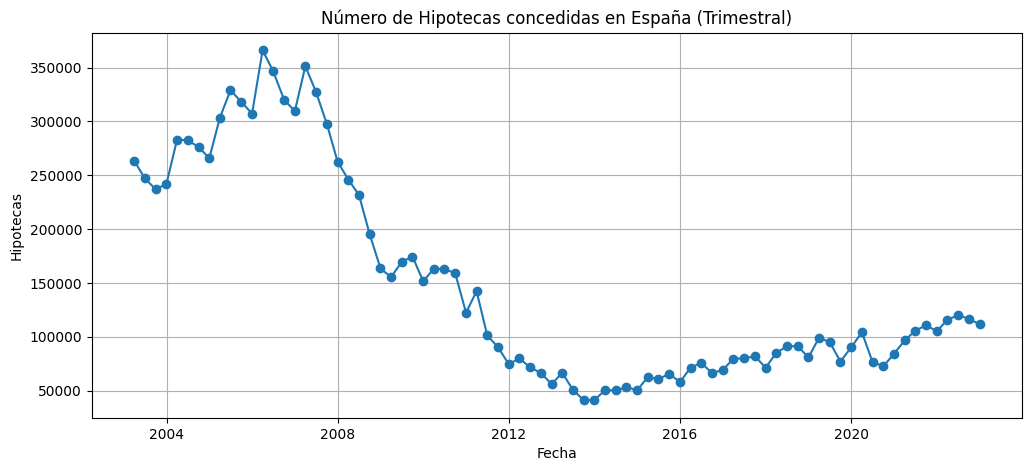

In [40]:
plt.figure(figsize=(12, 5))
plt.plot(serie_train, marker='o')
plt.title("Número de Hipotecas concedidas en España (Trimestral)")
plt.xlabel("Fecha")
plt.ylabel("Hipotecas")
plt.grid(True)
plt.show()

## Paso 3: Comprobación de estacionalidad y tendencia

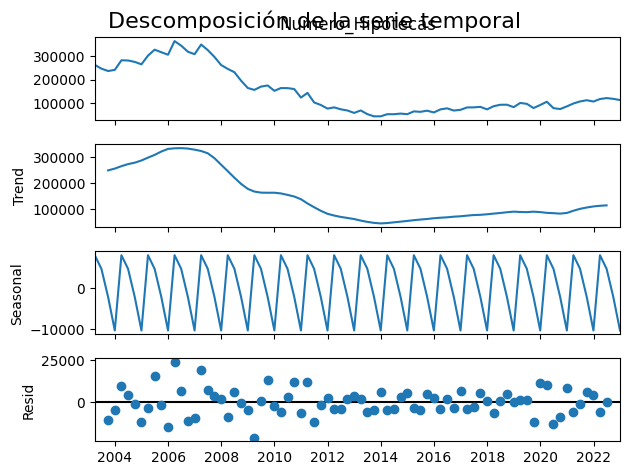

In [41]:
result = seasonal_decompose(serie_train, model='additive', period=4)  # 4 trimestres por año
result.plot()
plt.suptitle("Descomposición de la serie temporal", fontsize=16)
plt.show()

## Paso 4: Test de estacionariedad (Dickey-Fuller)

In [42]:
adf_result = adfuller(serie_train)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.9751590897572295
p-value: 0.29757004427355616


El p-value es mayor a 0.05, lo que indica que la serie no es estacionaria.
Por tanto, es necesario aplicar una diferenciación para estabilizar la media y permitir el uso de modelos ARIMA/SARIMA.

## Paso 5: Diferenciación de la serie y nuevo test ADF

In [43]:
# Diferenciamos la serie
serie_diff = serie_train.diff().dropna()

# Repetimos el test ADF
adf_diff = adfuller(serie_diff)

print("ADF Statistic (d=1):", adf_diff[0])
print("p-value:", adf_diff[1])


ADF Statistic (d=1): -2.316503635126042
p-value: 0.16670045309658327


El p-value sigue siendo mayor a 0.05, por lo que no se puede rechazar la hipótesis nula de que la serie aún no es estacionaria.
Esto significa que una sola diferenciación no es suficiente, y por tanto vamos a aplicar una segunda diferenciación (d=2), algo que en datos macroeconómicos de largo plazo no es inusual, especialmente cuando hay una combinación de tendencia y estacionalidad fuerte

### Segunda Diferenciación

In [44]:
# Segunda diferenciación
serie_diff2 = serie_train.diff().diff().dropna()

# Test ADF sobre la segunda diferenciación
adf_diff2 = adfuller(serie_diff2)

print("ADF Statistic (d=2):", adf_diff2[0])
print("p-value:", adf_diff2[1])


ADF Statistic (d=2): -15.784933470597675
p-value: 1.1197138394909665e-28


El p-value es prácticamente cero, muy por debajo del umbral del 0.05.

Por tanto, la serie diferenciada dos veces es estacionaria.

Podemos proceder a ajustar un modelo SARIMA con d=2 para capturar tanto las dinámicas temporales como la estacionalidad trimestral.



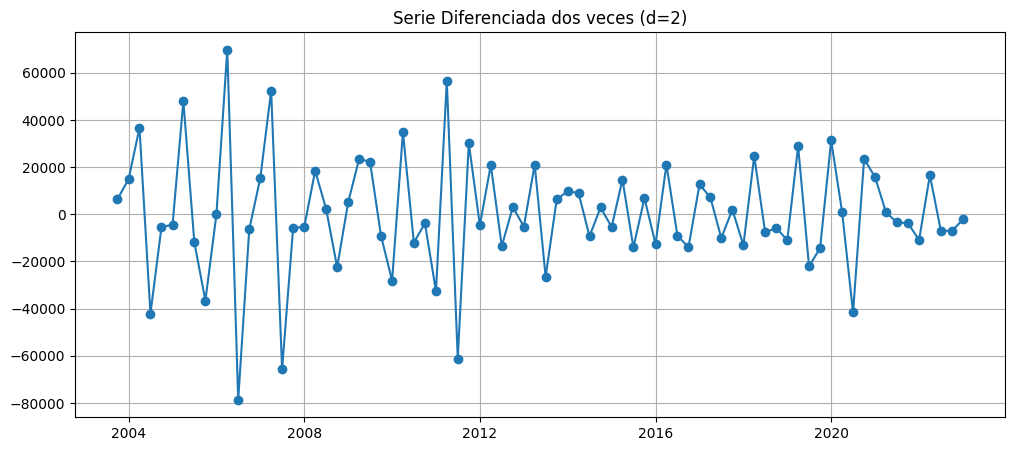

In [45]:
plt.figure(figsize=(12, 5))
plt.plot(serie_diff2, marker='o')
plt.title("Serie Diferenciada dos veces (d=2)")
plt.grid(True)
plt.show()


## Paso 7: Ajuste del modelo SARIMA

In [46]:
# Entrenamiento del modelo SARIMA (d=2, estacionalidad trimestral s=4)
modelo_sarima = SARIMAX(serie_train,
                        order=(1,2,1),
                        seasonal_order=(1,1,1,4),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

resultado = modelo_sarima.fit()
print(resultado.summary())

                                     SARIMAX Results                                     
Dep. Variable:                  Numero_Hipotecas   No. Observations:                   80
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 4)   Log Likelihood                -757.064
Date:                           Wed, 09 Jul 2025   AIC                           1524.127
Time:                                   09:27:12   BIC                           1535.225
Sample:                               03-31-2003   HQIC                          1528.524
                                    - 12-31-2022                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1287      0.229     -0.561      0.574      -0.578       0.321
ma.L1         -0.6830      0.228     -2.995

C:\Users\luife\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\luife\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


## Paso 8: Predicción  y evaluación del modelo SARIMA

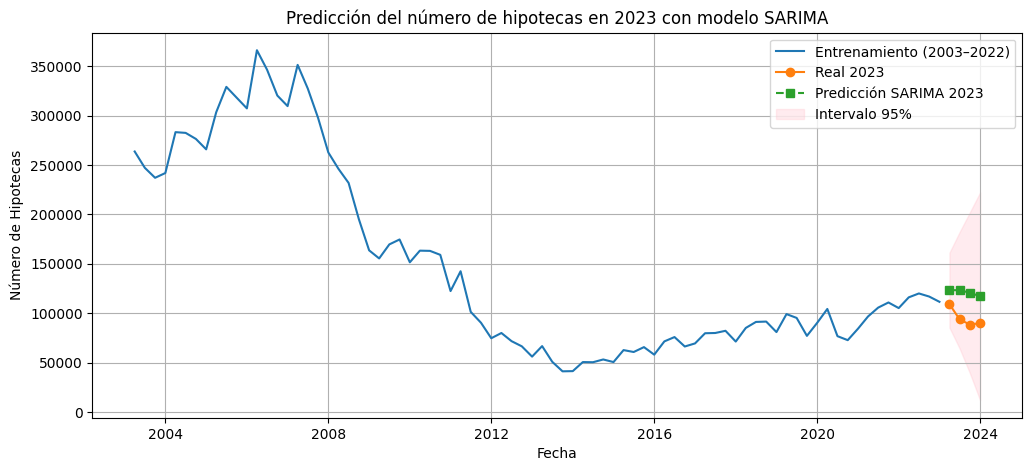

In [47]:
forecast_sarima = resultado.get_forecast(steps=4)
pred_2023_sarima = forecast_sarima.predicted_mean

# Asignamos las fechas correspondientes a los trimestres de 2023
pred_2023_sarima.index = pd.to_datetime(['2023-03-31', '2023-06-30', '2023-09-30', '2023-12-31'])

# Intervalo de confianza del 95%
conf_int = forecast_sarima.conf_int()
conf_int.index = pred_2023_sarima.index

plt.figure(figsize=(12,5))
plt.plot(serie_train, label="Entrenamiento (2003–2022)")
plt.plot(serie_test, label="Real 2023", marker='o')
plt.plot(pred_2023_sarima, label="Predicción SARIMA 2023", linestyle='--', marker='s')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Intervalo 95%')
plt.title("Predicción del número de hipotecas en 2023 con modelo SARIMA")
plt.xlabel("Fecha")
plt.ylabel("Número de Hipotecas")
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# Cálculo de métricas de evaluación

# Valores reales del test
real_2023 = serie_test

# Cálculo de errores
rmse = np.sqrt(mean_squared_error(real_2023, pred_2023_sarima))
mae = mean_absolute_error(real_2023, pred_2023_sarima)

print(f"SARIMA (predicción 2023) -> RMSE: {rmse:.2f} | MAE: {mae:.2f}")

SARIMA (predicción 2023) -> RMSE: 26700.33 | MAE: 25787.33


In [49]:
comparacion_sarima = pd.DataFrame({
    "Hipotecas Reales": real_2023.values,
    "Predicción SARIMA": pred_2023_sarima,
    "Error Absoluto": np.abs(real_2023.values - pred_2023_sarima)
}, index=real_2023.index)

print(comparacion_sarima.round(0))

            Hipotecas Reales  Predicción SARIMA  Error Absoluto
Fecha                                                          
2023-03-31            109020           123237.0         14217.0
2023-06-30             93695           123183.0         29488.0
2023-09-30             88378           120665.0         32287.0
2023-12-31             89873           117030.0         27157.0


# 3. SARIMAX

In [50]:
# Creamos copia del DataFrame original
df_model = df.copy()

# Variable dependiente (target)
y = df_model["Numero_Hipotecas"]

# Variables exógenas: eliminamos columnas no útiles y la variable objetivo
exog = df_model.drop(columns=["Numero_Hipotecas"])

## Paso 2: División temporal en train y test

In [51]:
# Train: 2003 - 2022 / Test: 2023
y_train = y.loc[:'2022-12-31']
y_test = y.loc['2023-03-31':'2023-12-31']

exog_train = exog.loc[:'2022-12-31']
exog_test = exog.loc['2023-03-31':'2023-12-31']

## Paso 3: Entrenamiento de SARIMAX

In [52]:
# Definimos el modelo SARIMAX
modelo_sarimax = SARIMAX(endog=y_train,
                         exog=exog_train,
                         order=(1,1,1),  # configuración inicial
                         seasonal_order=(1,1,1,4),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

resultado_sarimax = modelo_sarimax.fit()
print(resultado_sarimax.summary())

C:\Users\luife\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\luife\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                  Numero_Hipotecas   No. Observations:                   80
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                -717.730
Date:                           Wed, 09 Jul 2025   AIC                           1459.461
Time:                                   09:27:13   BIC                           1486.270
Sample:                               03-31-2003   HQIC                          1470.097
                                    - 12-31-2022                                         
Covariance Type:                             opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Importe_Hipotecas        9.575e+04   9172.127     10.439      0.000    7.78e+04    1.14e+05
Nume

## Paso 4. Predicción sobre el conjunto de test

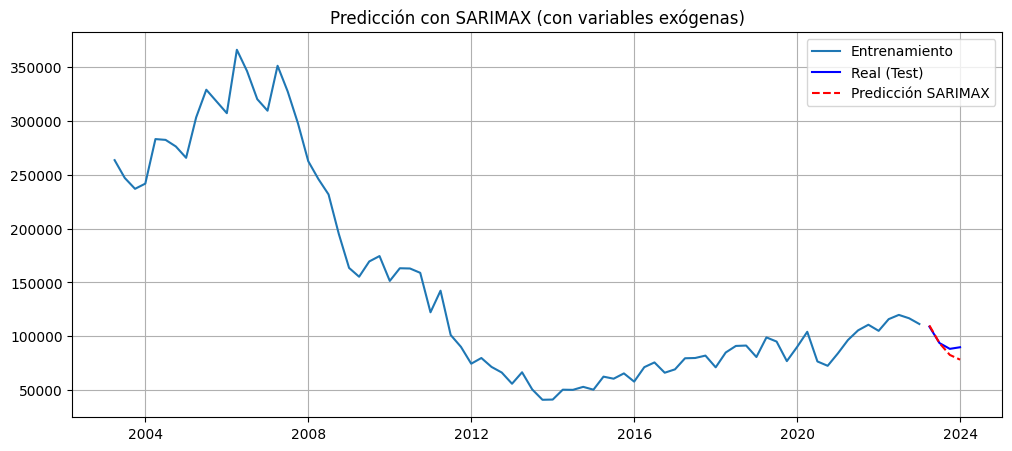

In [53]:
# Realizamos la predicción sobre los trimestres de test
pred_test = resultado_sarimax.predict(start=y_test.index[0], 
                                      end=y_test.index[-1], 
                                      exog=exog_test)

# Visualizamos la comparación
plt.figure(figsize=(12,5))
plt.plot(y_train, label="Entrenamiento")
plt.plot(y_test, label="Real (Test)", color='blue')
plt.plot(pred_test, label="Predicción SARIMAX", color='red', linestyle='--')
plt.title("Predicción con SARIMAX (con variables exógenas)")
plt.legend()
plt.grid(True)
plt.show()

## Paso 5. Evaluación del modelo

In [54]:
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)

print(f"RMSE (Test): {rmse:.2f}")
print(f"MAE (Test): {mae:.2f}")

RMSE (Test): 6439.55
MAE (Test): 4579.88


In [55]:
comparacion_sarimax = pd.DataFrame({
    "Hipotecas Reales": y_test.values,
    "Predicción SARIMAX": pred_test,
    "Error Absoluto": np.abs(y_test.values - pred_test)
}, index=y_test.index)

print(comparacion_sarimax.round(0))

            Hipotecas Reales  Predicción SARIMAX  Error Absoluto
Fecha                                                           
2023-03-31            109020            110102.0          1082.0
2023-06-30             93695             93618.0            77.0
2023-09-30             88378             82750.0          5628.0
2023-12-31             89873             78339.0         11534.0


Se ha mejorado mucho al incluir las variables. Hay que hacer apartado de conclusiones

# 4. Comparacón en gráficas

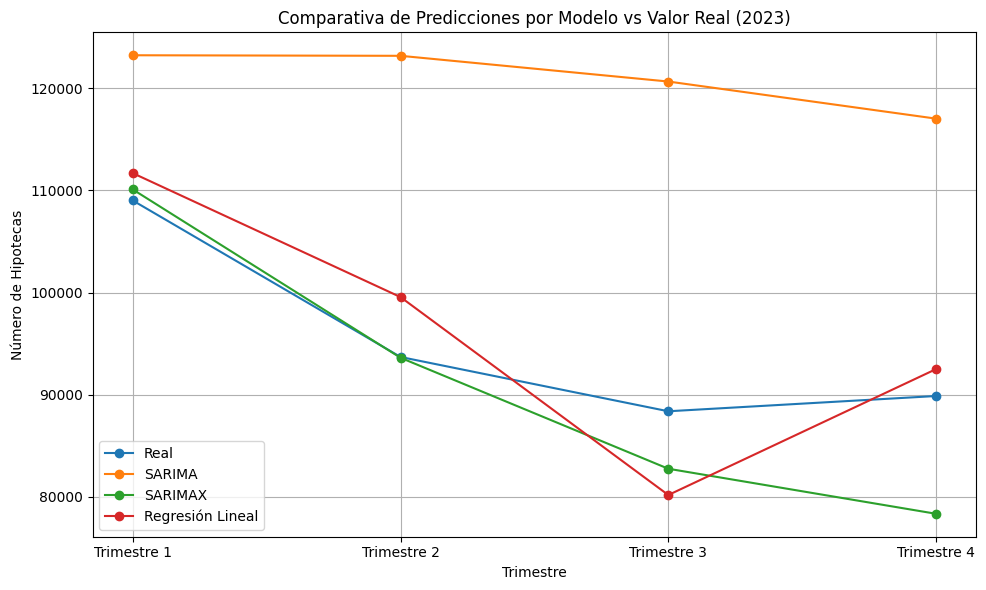

In [57]:
df_predicciones = pd.DataFrame({
    "Real": y_test,
    "SARIMA": pred_2023_sarima,
    "SARIMAX": pred_test,
    "Regresión Lineal": y_pred_2023
})


df_plot = df_predicciones.reset_index(drop=True)

etiquetas_trimestres = [f"Trimestre {i+1}" for i in range(len(df_plot))]

plt.figure(figsize=(10, 6))
for col in df_plot.columns:
    plt.plot(etiquetas_trimestres, df_plot[col], marker='o', label=col)

plt.title("Comparativa de Predicciones por Modelo vs Valor Real (2023)")
plt.xlabel("Trimestre")
plt.ylabel("Número de Hipotecas")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
